In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
moviesdf = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratingsdf = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
linksdf = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tagsdf = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [6]:
moviesdf.show(5)
type(moviesdf)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

 Out[ 5 ]: pyspark.sql.dataframe.DataFrame

In [7]:
ratingsdf.show(5)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [8]:
tmp1 = ratingsdf.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratingsdf.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [9]:
tmp1 = sum(ratingsdf.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratingsdf.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

## Part 1: Spark SQL and OLAP

### Q1: The number of Users

In [12]:
ratingsdf.select('userId').distinct().count()

Out[ 70 ]: 610

### Q2: The number of Movies

In [14]:
moviesdf.select('movieId').distinct().count()

Out[ 71 ]: 9742

### Q3:  How many movies are rated by users? List movies not rated before

In [16]:
moviesdf.show(1)

+-------+----------------+--------------------+
movieId| title| genres|
+-------+----------------+--------------------+
 1|Toy Story (1995)|Adventure|Animati...|
+-------+----------------+--------------------+
only showing top 1 row

In [17]:
ratingsdf.show(1)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
+------+-------+------+---------+
only showing top 1 row

In [18]:
moviesdf.select('title','movieId').join(
ratingsdf.select('movieId').distinct(),'movieId', 'left_anti').show()

+-------+--------------------+
movieId| title|
+-------+--------------------+
 1076|Innocents, The (1...|
 2939| Niagara (1953)|
 3338|For All Mankind (...|
 3456|Color of Paradise...|
 4194|I Know Where I'm ...|
 5721| Chosen, The (1981)|
 6668|Road Home, The (W...|
 6849| Scrooge (1970)|
 7020| Proof (1991)|
 7792|Parallax View, Th...|
 8765|This Gun for Hire...|
 25855|Roaring Twenties,...|
 26085|Mutiny on the Bou...|
 30892|In the Realms of ...|
 32160|Twentieth Century...|
 32371|Call Northside 77...|
 34482|Browning Version,...|
 85565| Chalet Girl (2011)|
+-------+--------------------+

### Q4: List Movie Genres

In [20]:
from pyspark.sql.functions import countDistinct, explode, split
movie_genre = moviesdf.withColumn('genre', explode(split(moviesdf.genres, '\|')))
# pick distinct genre
genres_list = movie_genre.filter(movie_genre.genre != '(no genres listed)') \
                     .select(movie_genre.genre).distinct() \
                     .orderBy(movie_genre.genre).show(2)

+---------+
 genre|
+---------+
 Action|
Adventure|
+---------+
only showing top 2 rows

### Q5: Movie for Each Category

In [22]:
from pyspark.sql.functions import concat_ws,collect_list
result = movie_genre \
                    .groupBy(movie_genre.genre) \
                    .agg(concat_ws(',', collect_list(movie_genre.title)) \
                    .alias('title')) \
                    .orderBy('genre')
result.show(2)

+------------------+--------------------+
 genre| title|
+------------------+--------------------+
(no genres listed)|La cravate (1957)...|
 Action|Heat (1995),Sudde...|
+------------------+--------------------+
only showing top 2 rows

## Part2: Spark ALS based approach for training model
We will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

In [24]:
from pyspark.mllib.recommendation import ALS

In [25]:
movie_ratingrdd = sc.textFile("/FileStore/tables/ratings.csv")

In [26]:
header = movie_ratingrdd.take(1)[0]
rating_datardd = movie_ratingrdd.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens:(int(tokens[0]), int(tokens[1]), float(tokens[2]))).cache()

In [27]:
# create dataframe from rdd
rating_datadf=spark.createDataFrame(rating_datardd)

rating_datadf = rating_datadf \
                    .withColumnRenamed('_1', 'userId') \
                    .withColumnRenamed('_2', 'movieId') \
                    .withColumnRenamed('_3', 'rating')

In [28]:
rating_datadf.show(5)

+------+-------+------+
userId|movieId|rating|
+------+-------+------+
 1| 1| 4.0|
 1| 3| 4.0|
 1| 6| 4.0|
 1| 47| 5.0|
 1| 50| 5.0|
+------+-------+------+
only showing top 5 rows

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [30]:
train, validation, test = rating_datardd.randomSplit([6,2,2],seed = 7856)# $view_point: rdd.randomSplit

In [31]:
train.collect()

Out[ 15 ]: [(1, 1, 4.0),
 (1, 3, 4.0),
 (1, 6, 4.0),
 (1, 50, 5.0),
 (1, 70, 3.0),
 (1, 110, 4.0),
 (1, 163, 5.0),
 (1, 223, 3.0),
 (1, 231, 5.0),
 (1, 235, 4.0),
 (1, 260, 5.0),
 (1, 316, 3.0),
 (1, 333, 5.0),
 (1, 349, 4.0),
 (1, 356, 4.0),
 (1, 362, 5.0),
 (1, 423, 3.0),
 (1, 480, 4.0),
 (1, 500, 3.0),
 (1, 527, 5.0),
 (1, 552, 4.0),
 (1, 553, 5.0),
 (1, 592, 4.0),
 (1, 596, 5.0),
 (1, 608, 5.0),
 (1, 648, 3.0),
 (1, 661, 5.0),
 (1, 673, 3.0),
 (1, 780, 3.0),
 (1, 804, 4.0),
 (1, 1009, 3.0),
 (1, 1024, 5.0),
 (1, 1025, 5.0),
 (1, 1032, 5.0),
 (1, 1049, 5.0),
 (1, 1080, 5.0),
 (1, 1090, 4.0),
 (1, 1092, 5.0),
 (1, 1097, 5.0),
 (1, 1127, 4.0),
 (1, 1136, 5.0),
 (1, 1198, 5.0),
 (1, 1208, 4.0),
 (1, 1213, 5.0),
 (1, 1214, 4.0),
 (1, 1220, 5.0),
 (1, 1224, 5.0),
 (1, 1265, 4.0),
 (1, 1270, 5.0),
 (1, 1275, 5.0),
 (1, 1282, 5.0),
 (1, 1291, 5.0),
 (1, 1298, 5.0),
 (1, 1348, 4.0),
 (1, 1377, 3.0),
 (1, 1396, 3.0),
 (1, 1408, 3.0),
 (1, 1473, 4.0),
 (1, 1500, 4.0),
 (1, 1517, 5.0),
 (1, 1617, 5.0),
 (1, 1620, 4.0),
 (1, 1644, 3.0),
 (1, 1676, 3.0),
 (1, 1732, 5.0),
 (1, 1777, 4.0),
 (1, 1793, 4.0),
 (1, 1804, 5.0),
 (1, 1805, 4.0),
 (1, 1920, 4.0),
 (1, 2012, 4.0),
 (1, 2018, 5.0),
 (1, 2033, 5.0),
 (1, 2046, 4.0),
 (1, 2048, 5.0),
 (1, 2058, 5.0),
 (1, 2078, 5.0),
 (1, 2093, 3.0),
 (1, 2096, 4.0),
 (1, 2099, 4.0),
 (1, 2115, 5.0),
 (1, 2141, 5.0),
 (1, 2143, 4.0),
 (1, 2174, 4.0),
 (1, 2193, 4.0),
 (1, 2253, 2.0),
 (1, 2273, 4.0),
 (1, 2291, 5.0),
 (1, 2338, 2.0),
 (1, 2366, 4.0),
 (1, 2406, 4.0),
 (1, 2450, 4.0),
 (1, 2459, 5.0),
 (1, 2470, 5.0),
 (1, 2492, 4.0),
 (1, 2528, 3.0),
 (1, 2529, 5.0),
 (1, 2571, 5.0),
 (1, 2596, 5.0),
 (1, 2616, 4.0),
 (1, 2628, 4.0),
 (1, 2640, 4.0),
 (1, 2641, 5.0),
 (1, 2644, 4.0),
 (1, 2648, 4.0),
 (1, 2654, 5.0),
 (1, 2700, 5.0),
 (1, 2716, 5.0),
 (1, 2797, 4.0),
 (1, 2826, 4.0),
 (1, 2858, 5.0),
 (1, 2899, 5.0),
 (1, 2916, 4.0),
 (1, 2944, 5.0),
 (1, 2947, 5.0),
 (1, 2948, 5.0),
 (1, 2949, 5.0),
 (1, 2959, 5.0),
 (1, 2993, 5.0),
 (1, 3033, 5.0),
 (1, 3052, 5.0),
 (1, 3053, 5.0),
 (1, 3062, 4.0),
 (1, 3176, 1.0),
 (1, 3247, 3.0),
 (1, 3273, 5.0),
 (1, 3386, 5.0),
 (1, 3439, 4.0),
 (1, 3440, 4.0),
 (1, 3450, 5.0),
 (1, 3479, 4.0),
 (1, 3578, 5.0),
 (1, 3639, 4.0),
 (1, 3671, 5.0),
 (1, 3729, 5.0),
 (1, 3744, 4.0),
 (1, 3793, 5.0),
 (1, 3809, 4.0),
 (1, 5060, 5.0),
 (2, 1704, 4.5),
 (2, 3578, 4.0),
 (2, 6874, 4.0),
 (2, 46970, 4.0),
 (2, 48516, 4.0),
 (2, 58559, 4.5),
 (2, 60756, 5.0),
 (2, 80489, 4.5),
 (2, 80906, 5.0),
 (2, 91529, 3.5),
 (2, 109487, 3.0),
 (2, 114060, 2.0),
 (2, 122882, 5.0),
 (3, 31, 0.5),
 (3, 647, 0.5),
 (3, 688, 0.5),
 (3, 720, 0.5),
 (3, 1124, 0.5),
 (3, 1263, 0.5),
 (3, 1275, 3.5),
 (3, 1302, 0.5),
 (3, 1371, 3.0),
 (3, 2018, 0.5),
 (3, 2080, 0.5),
 (3, 2090, 0.5),
 (3, 2105, 2.0),
 (3, 2424, 0.5),
 (3, 3210, 0.5),
 (3, 3703, 5.0),
 (3, 4518, 5.0),
 (3, 5048, 0.5),
 (3, 6238, 0.5),
 (3, 6835, 5.0),
 (3, 7991, 5.0),
 (3, 70946, 5.0),
 (3, 72378, 0.5),
 (4, 21, 3.0),
 (4, 52, 3.0),
 (4, 106, 4.0),
 (4, 125, 5.0),
 (4, 126, 1.0),
 (4, 171, 3.0),
 (4, 176, 5.0),
 (4, 215, 5.0),
 (4, 222, 1.0),
 (4, 232, 5.0),
 (4, 235, 2.0),
 (4, 247, 3.0),
 (4, 265, 5.0),
 (4, 319, 5.0),
 (4, 342, 5.0),
 (4, 345, 4.0),
 (4, 351, 3.0),
 (4, 368, 4.0),
 (4, 441, 1.0),
 (4, 457, 5.0),
 (4, 475, 5.0),
 (4, 492, 5.0),
 (4, 553, 2.0),
 (4, 588, 4.0),
 (4, 595, 3.0),
 (4, 608, 5.0),
 (4, 708, 4.0),
 (4, 759, 3.0),
 (4, 892, 4.0),
 (4, 898, 5.0),
 (4, 899, 4.0),
 (4, 904, 4.0),
 (4, 908, 5.0),
 (4, 920, 5.0),
 (4, 930, 5.0),
 (4, 937, 3.0),
 (4, 1025, 4.0),
 (4, 1046, 5.0),
 (4, 1057, 3.0),
 (4, 1060, 2.0),
 (4, 1073, 4.0),
 (4, 1077, 5.0),
 (4, 1079, 2.0),
 (4, 1084, 5.0),
 (4, 1086, 5.0),
 (4, 1094, 3.0),
 (4, 1136, 5.0),
 (4, 1179, 4.0),
 (4, 1197, 5.0),
 (4, 1199, 2.0),
 (4, 1203, 5.0),
 (4, 1211, 1.0),
 (4, 1250, 5.0),
 (4, 1265, 4.0),
 (4, 1282, 5.0),
 (4, 1283, 5.0),
 (4, 1291, 4.0),
 (4, 1304, 3.0),
 (4, 1391, 1.0),
 (4, 1466, 4.0),
 (4, 1500, 4.0),
 (4, 1517, 4.0),
 (4, 1597, 1.0),
 (4, 1617

In [32]:
train.collect()
traindf=spark.createDataFrame(train)
traindf=traindf\
              .withColumnRenamed('_1', 'userId') \
              .withColumnRenamed('_2', 'movieId') \
              .withColumnRenamed('_3', 'rating')

In [33]:
validation.cache()
valdf=spark.createDataFrame(validation)
valdf=valdf\
           .withColumnRenamed('_1', 'userId') \
           .withColumnRenamed('_2', 'movieId') \
           .withColumnRenamed('_3', 'rating')

In [34]:
test.cache()
testdf=spark.createDataFrame(test)
testdf=testdf\
           .withColumnRenamed('_1', 'userId') \
           .withColumnRenamed('_2', 'movieId') \
           .withColumnRenamed('_3', 'rating')

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [36]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [37]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # write your approach to train ALS model
            als = ALS(maxIter=num_iters, regParam=reg, userCol="userId", itemCol="movieId", ratingCol="rating", rank=rank, coldStartStrategy="drop")
            
            
            
            model=als.fit(train_data)
            
            # make prediction
            predictions=model.transform(validation_data)
            # get the rating result
            predictions.select('prediction').show(5)
            #print('\n The rating result is {}'.format(predictions))
            
            # get the RMSE
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            error =rmse
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = 'test'
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [38]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]


import time
start_time = time.time()
final_model = train_ALS(traindf, valdf, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

+----------+
prediction|
+----------+
 2.3304772|
 3.065381|
 2.043518|
 2.4165392|
 2.284784|
+----------+
only showing top 5 rows

6 latent factors and regularization = 0.05: validation RMSE is 0.9683596429568418
+----------+
prediction|
+----------+
 2.6450038|
 3.1213102|
 2.2929933|
 2.6690803|
 2.9135547|
+----------+
only showing top 5 rows

6 latent factors and regularization = 0.1: validation RMSE is 0.9083612074577333
+----------+
prediction|
+----------+
 2.9789326|
 3.2863865|
 2.568386|
 2.8081882|
 3.341703|
+----------+
only showing top 5 rows

6 latent factors and regularization = 0.2: validation RMSE is 0.89370572905598
+----------+
prediction|
+----------+
 2.9461205|
 3.0660038|
 2.5237408|
 2.8117518|
 3.3618817|
+----------+
only showing top 5 rows

6 latent factors and regularization = 0.4: validation RMSE is 0.9662159085576291
+----------+
prediction|
+----------+
 2.5619931|
 2.6555567|
 2.170655|
 2.5188487|
 2.9052765|
+----------+
only showing top 5 rows

6 latent factors and regularization = 0.8: validation RMSE is 1.1894181738003846
+----------+
prediction|
+----------+
 3.056083|
 3.0558643|
 3.076201|
 1.5352439|
 3.6093605|
+----------+
only showing top 5 rows

8 latent factors and regularization = 0.05: validation RMSE is 0.9874342295932284
+----------+
prediction|
+----------+
 3.1149185|
 3.2182286|
 2.7433422|
 1.7757797|
 3.5025568|
+----------+
only showing top 5 rows

8 latent factors and regularization = 0.1: validation RMSE is 0.9139297595734895
+----------+
prediction|
+----------+
 2.9967844|
 3.2149963|
 2.5978036|
 2.4650779|
 3.4470353|
+----------+
only showing top 5 rows

8 latent factors and regularization = 0.2: validation RMSE is 0.8958665651066589
+----------+
prediction|
+----------+
 2.943634|
 3.064369|
 2.521017|
 2.8092935|
 3.3589275|
+----------+
only showing top 5 rows

8 latent factors and regularization = 0.4: validation RMSE is 0.9667134557601563
+----------+
prediction|
+----------+
 2.562008|
 2.6555862|
 2.1707125|
 2.5188649|
 2.9053438|
+----------+
only showing top 5 rows

8 latent factors and regularization = 0.8: validation RMSE is 1.1894104824184166
+----------+
prediction|
+----------+
 3.5938003|
 4.639476|
 2.7245688|
 2.1633472|
 3.4789464|
+----------+
only showing top 5 rows

10 latent factors and regularization = 0.05: validation RMSE is 0.9970211991649047
+----------+
prediction|
+----------+
 3.2477617|
 4.201115|
 2.6544328|
 2.305402|
 3.5354643|
+----------+
only showing top 5 rows

10 latent factors and regularization = 0.1: validation RMSE is 0.9168643812741895
+----------+
prediction|
+----------+
 3.041514|
 3.383359|
 2.6536376|
 2.6341882|
 3.514317|
+----------+
only showing top 5 rows

10 latent factors and regularization = 0.2: validation RMSE is 0.8954205081875244
+----------+
prediction|
+----------+
 2.944139|
 3.0634642|
 2.5228076|
 2.818466|
 3.3603306|
+----------+
only showing top 5 rows

10 latent factors and regularization = 0.4: validation RMSE is 0.9665584224848655
+----------+
prediction|
+----------+
 2.5620046|
 2.6555727|
 2.1706831|
 2.5188751|
 2.905298|
+----------+
only showing top 5 rows

10 latent factors and regularization = 0.8: validation RMSE is 1.189411306707715
+----------+
prediction|
+----------+
 3.1423645|
 3.3471904|
 2.16645|
 2.5554566|
 3.2682772|
+----------+
only showing top 5 rows

12 latent factors and regularization = 0.05: validation RMSE is 0.9961827797916127
+----------+
prediction|
+----------+
 2.9051857|
 3.3462257|
 2.2593987|
 2.6486094|
 3.4689758|
+----------+
only showing top 5 rows

12 latent factors and regularization = 0.1: validation RMSE is 0.9124722232244262
+----------+
prediction|
+----------+
 2.93676|
 3.1770947|
 2.534728|
 2.8460767|
 3.4833512|
+----------+
only showing top 5 rows

12 latent factors and regularization = 0.2: validation RMSE is 0.8963322246916926
+----------+
prediction|
+----------+
 2.9431336|
 3.0637274|
 2.5206242|
 2.8149235|
 3.3591504|
+----------+


In [39]:
#write function of learning curve
def plot_learning_curve(iter_array,train,reg,ranks):
  alst1=[]
  for iter in iter_array:
    als=ALS(maxIter=iter,regParam=reg,userCol="userId", itemCol="movieId", ratingCol="rating",rank=ranks,coldStartStrategy="drop")#ignore null value in the dataset
    model=als.fit(train)
    
    predictions=model.transform(train)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
    rmse1=evaluator.evaluate(predictions)
    alst1.append(rmse1)
  fig,ax=plt.subplots()
  ax.plot(iter_array,alst1,color='blue', marker='o')
  plt.xlabel('iter time')
  plt.ylabel('RMSE')
  display(fig)  
  return alst1

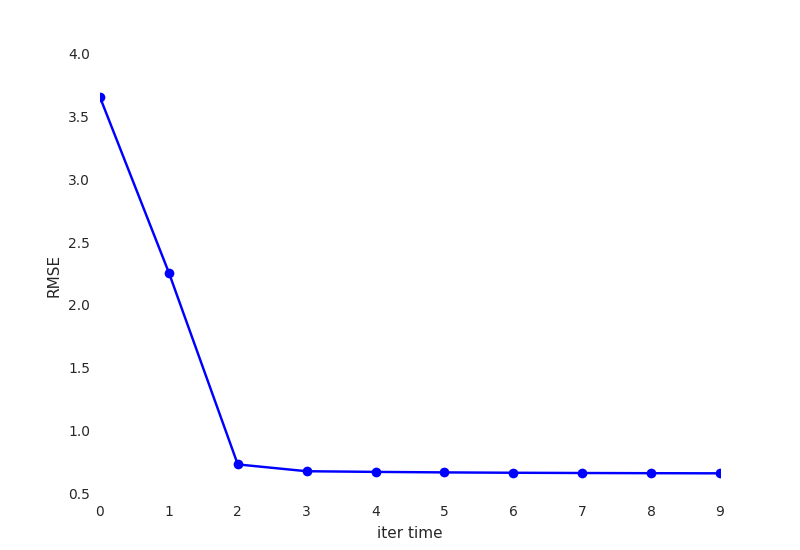

In [40]:
iter_array=[i for i in range(10)]
plot_learning_curve(iter_array, traindf, 0.2, 10)

### Model testing
And finally, make a prediction and check the testing error.

In [42]:
als=ALS(maxIter=2,regParam=0.2,userCol="userId", itemCol="movieId", ratingCol="rating",rank=10,coldStartStrategy="drop")
model=als.fit(testdf)
predictions_test=model.transform(testdf)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse=evaluator.evaluate(predictions_test)

In [43]:
predictions_test.show()

+------+-------+------+----------+
userId|movieId|rating|prediction|
+------+-------+------+----------+
 603| 471| 4.0| 2.5518358|
 500| 471| 1.0| 1.2439817|
 57| 471| 3.0| 1.8101827|
 555| 471| 3.0| 2.7053058|
 520| 471| 5.0| 4.117511|
 273| 471| 5.0| 5.1553297|
 608| 471| 1.5| 0.9081246|
 373| 471| 5.0| 4.1946883|
 608| 833| 0.5| 0.3972426|
 599| 1088| 2.5| 3.4797947|
 47| 1088| 4.0| 3.590843|
 132| 1088| 4.0| 3.3854954|
 286| 1088| 3.5| 3.7238708|
 555| 1088| 4.0| 3.9298878|
 84| 1088| 3.0| 3.7523384|
 42| 1088| 3.0| 2.988655|
 385| 1238| 3.0| 2.3805313|
 462| 1238| 3.5| 3.5367527|
 469| 1238| 5.0| 4.195147|
 325| 1342| 4.0| 3.7519193|
+------+-------+------+----------+
only showing top 20 rows

In [44]:
predictions_test.select('prediction').orderBy('prediction').show()

+-----------+
 prediction|
+-----------+
 -0.3542741|
 0.05048901|
0.079935655|
 0.08252136|
 0.16614509|
 0.18379892|
 0.19900927|
 0.1997952|
 0.25118855|
 0.26591378|
 0.29107922|
 0.31303692|
 0.3423351|
 0.34795278|
 0.35149187|
 0.35228902|
 0.35677743|
 0.358534|
 0.35953823|
 0.3679938|
+-----------+
only showing top 20 rows

In [45]:
print('The rmse of test dataset is {}'.format(rmse))

The rmse of test dataset is 0.6450178976303242

### Apply your Model

In [47]:
def get_movieId(moviesdf, fav_movie_list):
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = moviesdf \
            .filter(moviesdf.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))
def add_new_user_to_data(train, movieId_list, sc):
    #add this user to training dataset
    # get new user id
    new_id = train.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = sc.parallelize(user_rows)
    # get new train data
    train_datardd=train.union(new_rdd)
    
    return train_datardd
def get_inference_data(train, moviesdf, movieId_list):
   
    # get new user id
    new_id = train.map(lambda r: r[0]).max() + 1
    # return inference rdd
    movies_rddtemp= moviesdf.rdd \
                   .map(lambda r: r[0]) \
                   .distinct() \
                   .filter(lambda x: x not in movieId_list) \
                   .map(lambda x: (new_id, x)).cache()
    test_df=spark.createDataFrame(movies_rddtemp)
    
    return test_df


In [48]:
def get_movieId(moviesdf, fav_movie_list):
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = moviesdf \
            .filter(moviesdf.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))

In [49]:
fav_movie_list=['Toy Story (1995)']

In [50]:
movieId_list=get_movieId(moviesdf, fav_movie_list)
movieId_list

Out[ 32 ]: ['1']

In [51]:
def add_new_user_to_data(train, movieId_list, sc):
    #add this user to training dataset
    # get new user id
    new_id = train.map(lambda r: r[0]).max() + 1
    #print(new_id)
    # get max rating
    max_rating = train.map(lambda r: r[2]).max()
    # create new user rdd
    for movieId in movieId_list:
      user_rows = [(new_id, movieId, max_rating)]
      #print('$$$',user_rows)
      
    new_rdd = sc.parallelize(user_rows)
    
    # get new train data
    train_datardd=train.union(new_rdd)
    #train_datardd=add_new_user_to_data(train, movieId_list, sc)
    train_datardd=train_datardd.map(lambda x:(x[0],int(x[1]),x[2]))#$review point: createDataFrame data type must be converted,otherwise show none value
    train_datadf=spark.createDataFrame(train_datardd,['userId','movieId','rating'])
    return train_datadf

In [52]:
train_datadf=add_new_user_to_data(train,movieId_list, sc)
train_datadf.filter(train_datadf.userId==611).show()

+------+-------+------+
userId|movieId|rating|
+------+-------+------+
 611| 1| 5.0|
+------+-------+------+

In [53]:
def get_inference_data(train, moviesdf, movieId_list):
   
    # get new user id
    new_id = train.map(lambda r: r[0]).max() + 1
    # return inference rdd
    movies_rddtemp= moviesdf.rdd \
                   .map(lambda x:x[0])\
                   .distinct()\
                   .filter(lambda x: x not in movieId_list)\
                   .map(lambda x: (new_id, x))\
                   .map(lambda x:(x[0],int(x[1])))\
                   .cache()
    
    
    test_df=spark.createDataFrame(movies_rddtemp,['userId','movieId'])
    
    return test_df
    

In [54]:
from pyspark.sql.types import IntegerType
test_df=get_inference_data(train,moviesdf,movieId_list)
test_df.show()
#test_df.take(1)

+------+-------+
userId|movieId|
+------+-------+
 611| 90647|
 611| 4334|
 611| 66798|
 611| 94919|
 611| 66934|
 611| 2265|
 611| 1606|
 611| 3445|
 611| 3076|
 611| 106889|
 611| 5023|
 611| 3690|
 611| 145|
 611| 2597|
 611| 7706|
 611| 1867|
 611| 2232|
 611| 1281|
 611| 95843|
 611| 7357|
+------+-------+
only showing top 20 rows

In [55]:
als= ALS(maxIter=2,rank=10,regParam=0.2,userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy="drop")
model=als.fit(train_datadf)
predictions=model.transform(test_df)

In [56]:
predictions.show(2)

+------+-------+----------+
userId|movieId|prediction|
+------+-------+----------+
 611| 148| 1.9038787|
 611| 471| 4.6431236|
+------+-------+----------+
only showing top 2 rows

In [57]:
top_n=10 #get the top 10 highest movies rating
recommend_movies_lst=predictions.sort("prediction", ascending=False).take(10)
recommend_movies_lst

Out[ 63 ]: [Row(userId=611, movieId=43376, prediction=6.327129364013672),
 Row(userId=611, movieId=27619, prediction=6.2507643699646),
 Row(userId=611, movieId=4495, prediction=5.960278034210205),
 Row(userId=611, movieId=8235, prediction=5.960278034210205),
 Row(userId=611, movieId=6201, prediction=5.960278034210205),
 Row(userId=611, movieId=2730, prediction=5.952817440032959),
 Row(userId=611, movieId=3224, prediction=5.942287445068359),
 Row(userId=611, movieId=2726, prediction=5.918776035308838),
 Row(userId=611, movieId=1611, prediction=5.905204772949219),
 Row(userId=611, movieId=3451, prediction=5.859219074249268)]

In [58]:
recommend_movies_lst[9][1]

Out[ 64 ]: 3451

In [59]:
def getMovieId(recommend_movies_lst):
  recommendlst=[]
  n=len(recommend_movies_lst)  
  for i in range(n):
    recommendlst.append(recommend_movies_lst[i][1])
    
  return recommendlst
  

In [60]:
recommend_movies_lst=getMovieId(recommend_movies_lst)

In [61]:
recommend_movies_lst

Out[ 67 ]: [43376, 27619, 4495, 8235, 6201, 2730, 3224, 2726, 1611, 3451]

In [62]:
moviesdf.filter(moviesdf.movieId.isin(recommend_movies_lst)).show()

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1611|My Own Private Id...| Drama|Romance|
 2726| Killing, The (1956)| Crime|Film-Noir|
 2730| Barry Lyndon (1975)| Drama|Romance|War|
 3224|Woman in the Dune...| Drama|
 3451|Guess Who's Comin...| Drama|
 4495|Crossing Delancey...| Comedy|Romance|
 6201| Lady Jane (1986)| Drama|Romance|
 8235| Safety Last! (1923)|Action|Comedy|Rom...|
 27619|Lion King 1½, The...|Adventure|Animati...|
 43376|Sophie Scholl: Th...| Drama|War|
+-------+--------------------+--------------------+